In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr #corr coef
import time
from langdetect import detect, DetectorFactory

%matplotlib inline

### Context

The dataset contains Amazon reviews for several portable Bluetooth speakers from different high-end audio brands. It was sourced from data scraped from Amazon.com using the OxyLabs API.

1. **review_id:** Unique ID representing a single review
2. **product_id:** Unique ASIN ID number representing a specific speaker
3. **title:** Title of review
4. **author:** Author of review
5. **rating:** User rating, ranging from 1 to 5
6. **content:** Text of review
7. **timestamp:** Date review was posted
8. **profile_id:** Unique ID attached to author's profile
9. **is_verified:** Whether user's account is verified or not
10. **helpful_count:** Count of user upvotes on review, based on accuracy of review rating and content
11. **product_attributes:** Characteristics about product, such as color, size, and style

In [64]:
# Load dataset
df = pd.read_csv("merged_csv_data.csv")

# Show top 5 rows
df.head()

,review_id,product_id,title,author,rating,content,timestamp,profile_id,is_verified,helpful_count,product_attributes
0,R2LQYVEK3JWJW2,B099TJGJ91,5.0 out of 5 stars Great clear and powerful sp...,LilliesofTruth,5,"The sound quality is absolutely exceptional, d...","Reviewed in the United States July 31, 2024",AGER2OA4FJUBXTG4D47RSLLBPTMA,True,2,Color: White Smoke
1,R2TB41OYEQ665X,B099TJGJ91,5.0 out of 5 stars Simply great.,Jake,5,I have thoroughly enjoyed my entire ownership ...,"Reviewed in the United States May 4, 2024",AHZBIFMKWWZHILYEIYOSP4AIA37Q,True,224,Color: Black
2,R2Y3WBHYS3U0M4,B099TJGJ91,5.0 out of 5 stars A premium speaker in a stur...,Reviewer MHM 3-5,5,I bought this speaker because I wanted a way t...,"Reviewed in the United States July 2, 2024",AH5F7QHDE5VKRAMBN43A5WPU4ADQ,True,100,Color: Black
3,R22BP3UXW8MVME,B099TJGJ91,5.0 out of 5 stars sound quality,Max,5,I'm absolutely thrilled with this speaker! The...,"Reviewed in the United States July 23, 2024",AHBACXI2N3R5HP7LWWUEPXQB3XYQ,True,0,Color: Stone Blue
4,RQALUUYJSIT6A,B099TJGJ91,5.0 out of 5 stars Portable Speaker,Jose,5,This is by far the best portable speaker I hav...,"Reviewed in the United States July 28, 2024",AEA76CNGB75445PR4RJJZF3BHM6A,True,1,Color: Green


In [63]:
# Get summary of information about dataset
df.info()
df.describe() #summary stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_id           1060 non-null   object
 1   product_id          1060 non-null   object
 2   title               1060 non-null   object
 3   author              1060 non-null   object
 4   rating              1060 non-null   int64 
 5   content             1060 non-null   object
 6   timestamp           1060 non-null   object
 7   profile_id          1055 non-null   object
 8   is_verified         1060 non-null   bool  
 9   helpful_count       1060 non-null   int64 
 10  product_attributes  1060 non-null   object
dtypes: bool(1), int64(2), object(8)
memory usage: 84.0+ KB


,rating,helpful_count
count,1060.000000,1060.000000
mean,4.580189,3.775472
std,0.886465,18.897131
min,1.000000,0.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,1.000000
max,5.000000,283.000000


There are a total of 1,060 reviews in the dataset. The average rating across all reviews is about 4.6. ... The average helpful count across all reviews is about 3. ...

## Data Cleaning

In this part, I will clean the dataset by checking for and handling missing values, corrupt values, outliers, duplicates, correcting data types, and performing other preprocessing steps.

In [65]:
# Make a deep copy of original dataset
cleandf = df.copy()

In [66]:
# Drop irrelevant columns
cleandf.drop(cleandf.columns[[3,7,8]], axis=1, inplace=True)
cleandf.head()

,review_id,product_id,title,rating,content,timestamp,helpful_count,product_attributes
0,R2LQYVEK3JWJW2,B099TJGJ91,5.0 out of 5 stars Great clear and powerful sp...,5,"The sound quality is absolutely exceptional, d...","Reviewed in the United States July 31, 2024",2,Color: White Smoke
1,R2TB41OYEQ665X,B099TJGJ91,5.0 out of 5 stars Simply great.,5,I have thoroughly enjoyed my entire ownership ...,"Reviewed in the United States May 4, 2024",224,Color: Black
2,R2Y3WBHYS3U0M4,B099TJGJ91,5.0 out of 5 stars A premium speaker in a stur...,5,I bought this speaker because I wanted a way t...,"Reviewed in the United States July 2, 2024",100,Color: Black
3,R22BP3UXW8MVME,B099TJGJ91,5.0 out of 5 stars sound quality,5,I'm absolutely thrilled with this speaker! The...,"Reviewed in the United States July 23, 2024",0,Color: Stone Blue
4,RQALUUYJSIT6A,B099TJGJ91,5.0 out of 5 stars Portable Speaker,5,This is by far the best portable speaker I hav...,"Reviewed in the United States July 28, 2024",1,Color: Green


In [67]:
# Check for duplicate data
cleandf[cleandf.duplicated()]

,review_id,product_id,title,rating,content,timestamp,helpful_count,product_attributes


There is no duplicate data in the dataset.

In [68]:
# Check for missing values
cleandf.isna().sum()

review_id             0
product_id            0
title                 0
rating                0
content               0
timestamp             0
helpful_count         0
product_attributes    0
dtype: int64

There are no missing values in the dataset. Before removing irrelevant columns, there were 5 missing values in the 'profile_id' column. However, the entire column was dropped, so it is no longer an issue.

In [70]:
# Check for corrupt values
for col in cleandf.columns:
    print(cleandf[col].unique())

['R2LQYVEK3JWJW2' 'R2TB41OYEQ665X' 'R2Y3WBHYS3U0M4' ... 'RDNZF4I13GKT4'
 'R2ZF60HWQ8L0NI' 'RGSIQ5EFETRO2']
['B099TJGJ91' 'B09GJVTRNZ' 'B08Z1C8NM9' 'B07DD3VXRZ' 'B09XXW54QG'
 'B08VL5S148' 'B0CXL4FQBK' 'B07P39MLKH' 'B08X4YMTPM' 'B016QXV2QK'
 'B0D4SX9RC6']
['5.0 out of 5 stars Great clear and powerful speaker'
 '5.0 out of 5 stars Simply great.'
 '5.0 out of 5 stars A premium speaker in a sturdy package.'
 '5.0 out of 5 stars sound quality' '5.0 out of 5 stars Portable Speaker'
 '5.0 out of 5 stars Sound quality'
 '4.0 out of 5 stars Small speaker, big sound, travel friendly'
 '5.0 out of 5 stars Gets loud enough for its size. (Or a bit too loud for neighbors)'
 '5.0 out of 5 stars 5 Million Stars!! ⭐⭐⭐⭐⭐'
 '4.0 out of 5 stars Surprisingly loud, no EQ controls, few caveats'
 '5.0 out of 5 stars Good sound, solid unit, but CONNECTION difficulties to know'
 '5.0 out of 5 stars Bose quality'
 '5.0 out of 5 stars BOSE for the WIN!!!'
 '5.0 out of 5 stars Best small portable bose speaker ever!

Most of the reviews contain extra text and non-alphanumeric characters that reduce readability. I will remove those characters.

In [71]:
cleandf['content'] = cleandf['content'].str.replace(r'^\d+\.\d+ out of 5 stars\s*', '', regex=True).str.replace(r'\W+', ' ', regex=True).str.strip()
cleandf['content']

0       The sound quality is absolutely exceptional de...
1       I have thoroughly enjoyed my entire ownership ...
2       I bought this speaker because I wanted a way t...
3       I m absolutely thrilled with this speaker The ...
4       This is by far the best portable speaker I hav...
                              ...                        
1055    Simple to use very simple to pair within the A...
1056    Upgraded from an Anker Soundcore 2 Considered ...
1057    It s compact and efficient with the lithium ba...
1058    Feels so solid of a device highly recommend it...
1059    The Goods As a Master s student looking for th...
Name: content, Length: 1060, dtype: object

In [73]:
cleandf[cleandf['title']=='']

,review_id,product_id,title,rating,content,timestamp,helpful_count,product_attributes


In [72]:
cleandf[cleandf['content']=='']

,review_id,product_id,title,rating,content,timestamp,helpful_count,product_attributes
879,R1I5WG0M6GEFI1,B08X4YMTPM,5.0 out of 5 stars 😀,5,,"Reviewed in the United States August 2, 2024",0,Color: Black
942,RP8GOOLI0HEU0,B016QXV2QK,5.0 out of 5 stars 💯,5,,"Reviewed in the United States June 4, 2023",0,Color: Black


Some of the reviews have no content/are blank. I will remove them.

In [74]:
indexContent = cleandf[cleandf['content']==''].index
cleandf.drop(indexContent, inplace=True)

Some of the titles and content are in languages other than English. I will find and remove them.

In [76]:
# Set a seed for the detector to reproduce results
DetectorFactory.seed = 0

texts = cleandf['content']  # Assuming cleandf is your DataFrame containing the 'content' column

# List to store the detected languages
detected_languages = []

def detect_language(text):
    try:
        if not text.strip():  # Check for empty or whitespace-only strings
            return 'unknown'
        return detect(text)
    except Exception as e:
        return 'error'

# Sequential processing of each text
for text in texts:
    detected_lang = detect_language(text)
    detected_languages.append(detected_lang)
    time.sleep(0.1)  # Optional: slight delay to avoid overloading the system

# Add detected languages as a new column
cleandf['language'] = detected_languages

# Display the DataFrame with detected languages
print(cleandf['language'])

0       en
1       en
2       en
3       en
4       en
        ..
1055    en
1056    en
1057    en
1058    en
1059    en
Name: language, Length: 1058, dtype: object


In [78]:
# Check all languages present
cleandf['language'].unique()

array(['en', 'es', 'da', 'ca', 'so', 'ro', 'de', 'fr', 'af', 'no', 'pt',
       'lt', 'id', 'sl'], dtype=object)

There were several languages detected, including English and Spanish. However, some of the reviews were too short to be correctly identified. I will remove all of those reviews.

In [79]:
cleandf.drop(cleandf.loc[cleandf['language'] != 'en'].index, inplace=True) #remove non-english reviews
print(cleandf.shape) #print number of reviews left

(990, 9)


I converted the 'timestamp' column from object to datetime type.

In [75]:
# Remove the text before the date
cleandf['timestamp'] = cleandf['timestamp'].str.replace(r'^Reviewed in .+? (\w+ \d{1,2}, \d{4})$', r'\1', regex=True)

# Convert text to datetime objects
cleandf['timestamp'] = pd.to_datetime(cleandf['timestamp'], format='%B %d, %Y')
cleandf['timestamp']

0      2024-07-31
1      2024-05-04
2      2024-07-02
3      2024-07-23
4      2024-07-28
          ...    
1055   2024-07-02
1056   2024-08-03
1057   2024-08-03
1058   2024-07-18
1059   2024-07-31
Name: timestamp, Length: 1058, dtype: datetime64[ns]

In [80]:
# View all unique product attributes
cleandf['product_attributes'].unique()

array(['Color: White Smoke', 'Color: Black', 'Color: Stone Blue',
       'Color: Green', 'Color: Chilled Lilac',
       'Color: BlackStyle: Flip 6', 'Color: TealStyle: Flip 6',
       'Color: CamoStyle: Flip 6', 'Color: PinkStyle: Flip 6',
       'Color: BlueStyle: Flip 6', 'Color: GreyStyle: Flip 6',
       'Color: WhiteStyle: Flip 6', 'Color: RedStyle: Flip 6',
       'Color: GreenStyle: Flip 6', 'Size: SingleColor: White',
       'Size: SingleColor: Black', 'Size: 2-PackColor: Black',
       'Size: 2-PackColor: White', 'Color: Night BlackPattern: Speaker',
       'Color: Lagoon BluePattern: Speaker',
       'Color: Sunset RedPattern: Speaker',
       'Color: Ultraviolet PurplePattern: Speaker',
       'Color: Ultraviolet PurplePattern: Speaker + Charging Dock',
       'Color: BlackStyle: Emberton',
       'Color: Black & BrassStyle: Emberton II',
       'Color: CreamStyle: Emberton II', 'Color: Silver',
       'Color: Off White', 'Color: Orange', 'Color: Forest Gray',
       'Color:

For the Marshall speaker, the reviews include both the Emberton and Emberton II styles. I only want reviews for the newer Emberton II style. So I will remove all reviews for the older version.

In [82]:
marshall_product_id = 'B09XXW54QG'
marshall_df = cleandf[cleandf['product_id'] == marshall_product_id]
marshall_ii_df = marshall_df[marshall_df['product_attributes'].str.contains("Style: Emberton II")]

# Filter rows that are not for Marshall speakers
other_ids_df = cleandf[cleandf['product_id'] != marshall_product_id]

# Combine the filtered rows with rest of the dataset
cleandf = pd.concat([marshall_ii_df, other_ids_df])

# Reset the index
cleandf = cleandf.reset_index(drop=True)

print(f"Number of Emberton reviews removed: {len(df)-len(cleandf)}")
print(f"Total reviews in dataset: {len(cleandf)}")

Number of Emberton reviews removed: 87
Total reviews in dataset: 973


Then, I created a column for the name of each product.

In [83]:
# Mapping ASIN numbers to product names
asin_to_product = {
    'B099TJGJ91': 'Bose SoundLink Flex',
    'B09GJVTRNZ': 'JBL Flip 6',
    'B08Z1C8NM9': 'Sonos Roam',
    'B07DD3VXRZ': 'Ultimate Ears Boom 3',
    'B09XXW54QG': 'Marshall Emberton II',
    'B08VL5S148': 'Bose SoundLink Revolve+ (Series II)',
    'B0CXL4FQBK': 'Sony ULT Field 1',
    'B07P39MLKH': 'Soundcore Motion+',
    'B08X4YMTPM': 'JBL Charge 5',
    'B016QXV2QK': 'Beats Pill Plus',
    'B0D4SX9RC6': 'Beats Pill'
}

# Create a new column for product names
cleandf['product_name'] = cleandf['product_id'].apply(lambda asin: asin_to_product.get(asin, 'unknown product'))

print(cleandf[['product_id', 'product_name']])

     product_id          product_name
0    B09XXW54QG  Marshall Emberton II
1    B09XXW54QG  Marshall Emberton II
2    B09XXW54QG  Marshall Emberton II
3    B09XXW54QG  Marshall Emberton II
4    B09XXW54QG  Marshall Emberton II
..          ...                   ...
968  B0D4SX9RC6            Beats Pill
969  B0D4SX9RC6            Beats Pill
970  B0D4SX9RC6            Beats Pill
971  B0D4SX9RC6            Beats Pill
972  B0D4SX9RC6            Beats Pill

[973 rows x 2 columns]


Then, I created a column for the price of each product.

In [84]:
# Mapping product names to product prices
product_to_price = {
    'Bose SoundLink Flex': 149.00,
    'JBL Flip 6': 129.95,
    'Sonos Roam': 179,
    'Ultimate Ears Boom 3': 149.99,
    'Marshall Emberton II': 169.99,
    'Bose SoundLink Revolve+ (Series II)': 329,
    'Sony ULT Field 1': 129.99,
    'Soundcore Motion+': 99.99,
    'JBL Charge 5': 179.95,
    'Beats Pill Plus': 229.95,
    'Beats Pill': 149.95
}

cleandf['product_price'] = cleandf['product_name'].apply(lambda price: product_to_price.get(price, 'unknown price'))
cleandf['product_price'] = pd.to_numeric(cleandf['product_price'], errors='coerce') #convert column to float

print(cleandf[['product_name', 'product_price']])

             product_name  product_price
0    Marshall Emberton II         169.99
1    Marshall Emberton II         169.99
2    Marshall Emberton II         169.99
3    Marshall Emberton II         169.99
4    Marshall Emberton II         169.99
..                    ...            ...
968            Beats Pill         149.95
969            Beats Pill         149.95
970            Beats Pill         149.95
971            Beats Pill         149.95
972            Beats Pill         149.95

[973 rows x 2 columns]


From the 'product_attributes' column, I created a separate 'color' column.

In [85]:
# Parse 'product_attributes' column to extract text
# and create a new column for color
cleandf['color'] = cleandf['product_attributes'].str.extract(r'Color:\s*([\w\s&]+?)(?=\s*(Style|Pattern|Size|$))')[0]
print(cleandf['color'])

0       Black & Brass
1               Cream
2       Black & Brass
3       Black & Brass
4               Cream
            ...      
968    Champagne Gold
969    Champagne Gold
970    Champagne Gold
971       Matte Black
972       Matte Black
Name: color, Length: 973, dtype: object


In [86]:
# Count the number of reviews for each color for each product
cleandf.groupby(['product_name', 'color']).size()

product_name                         color             
Beats Pill                           Champagne Gold        16
                                     Matte Black           33
                                     Statement Red          9
Beats Pill Plus                      Black                 70
                                     Red                   10
                                     White                 18
Bose SoundLink Flex                  Black                 25
                                     Chilled Lilac         14
                                     Green                 13
                                     Stone Blue            30
                                     White Smoke           17
Bose SoundLink Revolve+ (Series II)  Black                 71
                                     Silver                19
JBL Charge 5                         Black                 46
                                     Blue                  14
              

Then, I determined which color was most popular for each product.

In [87]:
# Find the most frequently occuring colors for each product
cleandf[['product_name', 'color']].groupby('product_name').agg(pd.Series.mode)

,color
product_name,
Beats Pill,Matte Black
Beats Pill Plus,Black
Bose SoundLink Flex,Stone Blue
Bose SoundLink Revolve+ (Series II),Black
JBL Charge 5,Black
JBL Flip 6,Black
Marshall Emberton II,Black & Brass
Sonos Roam,Black
Sony ULT Field 1,Orange


Then, I created a 'base_color' column to make data visualiztion simpler.

In [88]:
# Create a list of unique colors across all products
unique_colors = ['Gold','Black','Red','White','Lilac','Green','Blue','Silver','Camo','Gray','Grey','Pink','Teal','Cream','Orange','Purple']

# Create a 'base_color' column to establish generic color names
cleandf['base_color'] = [
    [color for color in unique_colors if color in item][0] if any(color in item for color in unique_colors) else np.nan
    for item in cleandf['color']
]

print(cleandf[['color', 'base_color']])
print("Number of missing colors =", cleandf['base_color'].isna().sum()) #check if any nulls

              color base_color
0     Black & Brass      Black
1             Cream      Cream
2     Black & Brass      Black
3     Black & Brass      Black
4             Cream      Cream
..              ...        ...
968  Champagne Gold       Gold
969  Champagne Gold       Gold
970  Champagne Gold       Gold
971     Matte Black      Black
972     Matte Black      Black

[973 rows x 2 columns]
Number of missing colors = 0


## EDA

In [90]:
# Make a deep copy of cleaned dataset
df1 = cleandf.copy()

In [91]:
df1.head()

,review_id,product_id,title,rating,content,timestamp,helpful_count,product_attributes,language,product_name,product_price,color,base_color
0,RL16ZWDRDNUEI,B09XXW54QG,5.0 out of 5 stars Great product with usage ca...,5,A few months ago I had an epiphany When I was ...,2022-10-01,155,Color: Black & BrassStyle: Emberton II,en,Marshall Emberton II,169.99,Black & Brass,Black
1,R3KP7M5UVOR8YT,B09XXW54QG,5.0 out of 5 stars Perfect for office!,5,Great sound from surprisingly compact unit Ful...,2024-06-21,0,Color: CreamStyle: Emberton II,en,Marshall Emberton II,169.99,Cream,Cream
2,R1B1NV04V8NIEM,B09XXW54QG,5.0 out of 5 stars Best portable Speaker!,5,Wow This tiny portable speaker packs a punch I...,2024-07-30,0,Color: Black & BrassStyle: Emberton II,en,Marshall Emberton II,169.99,Black & Brass,Black
3,R1N4D4CK1JMIVB,B09XXW54QG,4.0 out of 5 stars Three + 1/2 stars.,4,Feels churlish to give just three stars 3 5 im...,2024-02-28,9,Color: Black & BrassStyle: Emberton II,en,Marshall Emberton II,169.99,Black & Brass,Black
4,RG89Y4CD1UR6C,B09XXW54QG,"5.0 out of 5 stars I mean it’s alright, overra...",5,It s good but it does not hold the 30 hours wi...,2024-06-21,6,Color: CreamStyle: Emberton II,en,Marshall Emberton II,169.99,Cream,Cream


In [92]:
# Get summary statistics
df1.describe()

,rating,timestamp,helpful_count,product_price
count,973.000000,973,973.000000,973.000000
mean,4.560123,2023-09-23 17:55:55.806783232,4.063720,172.583443
min,1.000000,2015-12-03 00:00:00,0.000000,99.990000
25%,5.000000,2023-12-02 00:00:00,0.000000,129.990000
50%,5.000000,2024-06-10 00:00:00,0.000000,149.990000
75%,5.000000,2024-07-19 00:00:00,2.000000,179.950000
max,5.000000,2024-08-06 00:00:00,283.000000,329.000000
std,0.914972,NaN,19.681414,60.197469


Across all products, the average rating is about 4.6. Helpful count is generally very low. The average price is about $172. The prices range from about $100 to $329.

### Univariate Analysis

([<matplotlib.axis.XTick at 0x13728cb30>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

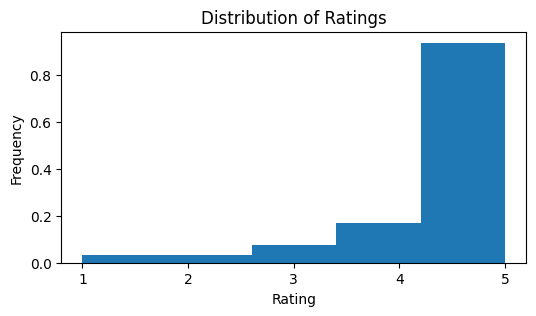

In [109]:
# Plot distribution of ratings
# 'rating' is a continuous data variable -> use histogram.

plt.figure(figsize=(6,3)) #create a figure w/ specified size
plt.hist(data=df1, x='rating', bins=5, density=True) #plot histogram w/ specified num of bins
plt.title('Distribution of Ratings') #add title
plt.xlabel('Rating') #add an x-axis label
plt.ylabel('Frequency') #add a y-axis label
plt.xticks([1,2,3,4,5]) #adjust x-axis ticks

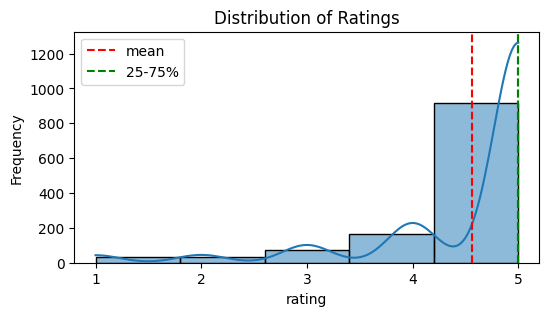

In [126]:
# Plot distribution of ratings
# 'rating' is a continuous data variable -> use histogram.

plt.figure(figsize=(6,3))
sns.histplot(data=df1, x='rating', stat='frequency', bins=5, kde=True) #plot histogram w/ kde curve
plt.axvline(x=np.mean(df1['rating']), c='red', ls='--', label='mean') #draw line for mean
plt.axvline(x=np.percentile(df['rating'], 25), c='green', ls='--', label='25-75%') #draw line for 25th percentile
plt.axvline(x=np.percentile(df['rating'], 75), c='green', ls='--') #draw line for 75th percentile
plt.title('Distribution of Ratings')
plt.xticks([1,2,3,4,5])
plt.legend()

The distribution of ratings is left-skewed, meaning that the products tend to have higher ratings.

array([[<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'timestamp'}>],
       [<Axes: title={'center': 'helpful_count'}>,
        <Axes: title={'center': 'product_price'}>]], dtype=object)

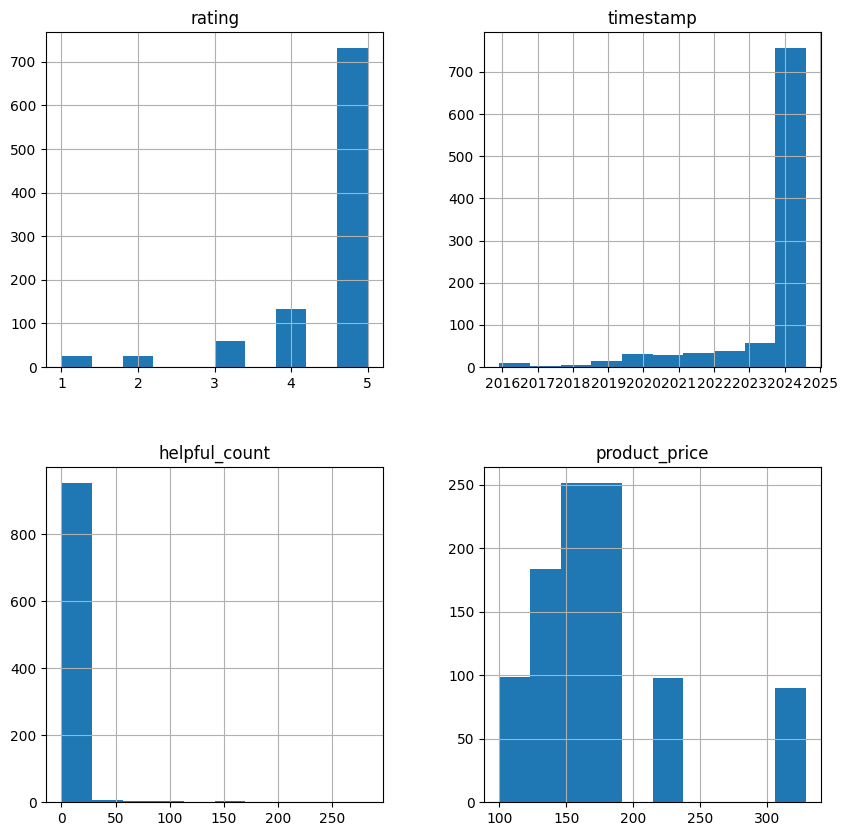

In [129]:
df1.hist(figsize=(10,10))

<Axes: xlabel='base_color', ylabel='count'>

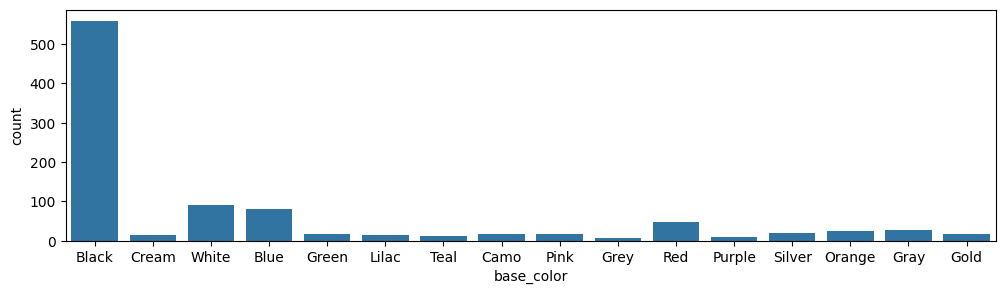

In [132]:
plt.figure(figsize=(8,3))
sns.countplot(data=df1, x='base_color')

<Axes: xlabel='base_color'>

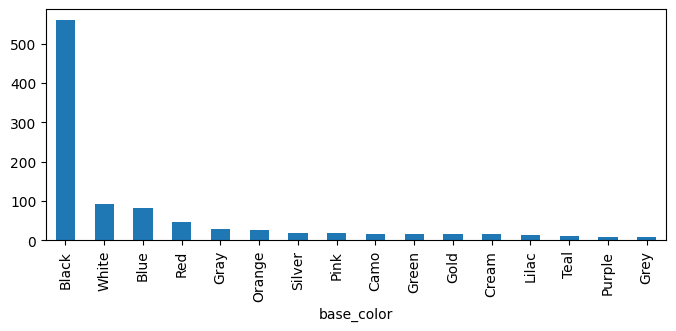

In [142]:
plt.figure(figsize=(8,3))
df1['base_color'].value_counts().plot(kind='bar')

### Bivariate Analysis

### Data Visualization

1. Identify Anomalies & Outliers

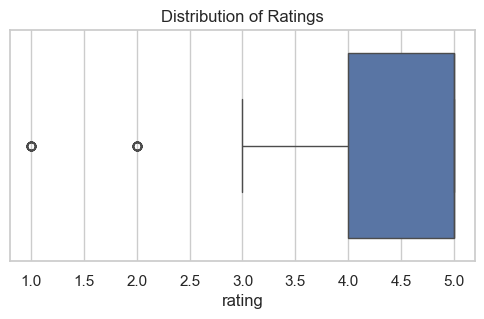

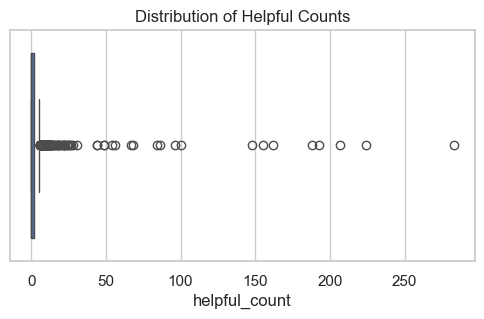

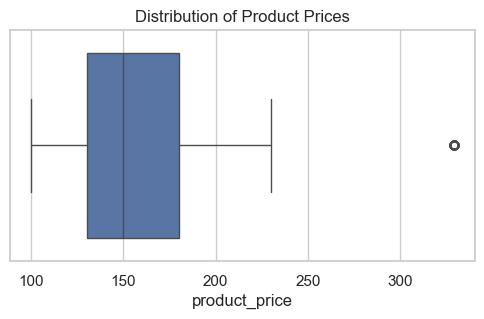

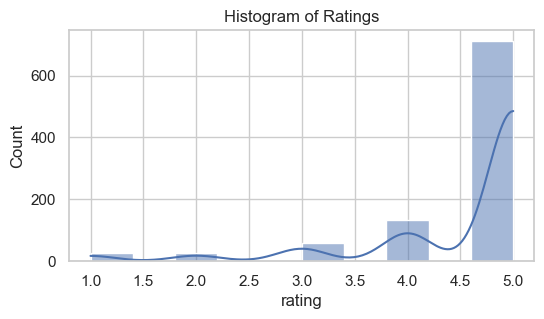

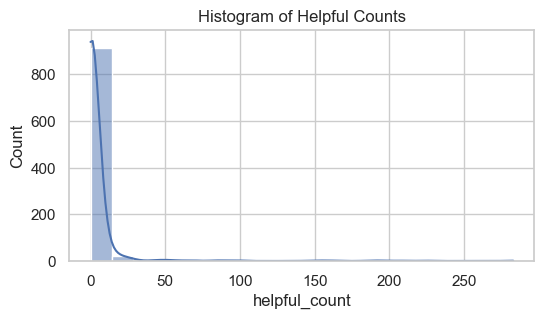

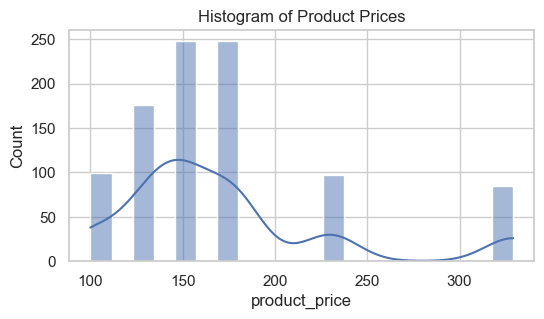

In [180]:
# Set the style for plots
sns.set(style="whitegrid")

plt.figure(figsize=(6, 3))
sns.boxplot(x=dfclean['helpful_count'])
plt.title('Distribution of Helpful Counts')
plt.show()

plt.figure(figsize=(6, 3))
sns.boxplot(x=dfclean['product_price'])
plt.title('Distribution of Product Prices')
plt.show()

# Visualize the distribution
plt.figure(figsize=(6, 3))
sns.histplot(dfclean['rating'], bins=10, kde=True)
plt.title('Histogram of Ratings')
plt.show()

plt.figure(figsize=(6, 3))
sns.histplot(dfclean['helpful_count'], bins=20, kde=True)
plt.title('Histogram of Helpful Counts')
plt.show()

plt.figure(figsize=(6, 3))
sns.histplot(dfclean['product_price'], bins=20, kde=True)
plt.title('Histogram of Product Prices')
plt.show()

Ratings:
* The distribution of ratings is heavily skewed towards the higher end, with most reviews being 4 or 5 stars.
* There are very few low ratings (1 or 2 stars), indicating generally positive feedback for the products.

Helpful Count:
* The distribution of helpful counts is highly skewed, with most reviews having very low or zero helpful counts.
* A few reviews have extremely high helpful counts (outliers), indicating these particular reviews were significantly more helpful to users.

Product Price:
* The distribution of product prices is somewhat bimodal, with a concentration around the $150-$180 range.
* There are a few products priced significantly higher, but no extreme outliers are evident.

2. Identify Trends, Patterns & Relationships

I will explore these trends:
* Ratings over time
* Most popular color over time

/var/folders/3b/mkytytxs3lq7m70p7zzw52mc0000gn/T/ipykernel_5334/2764034871.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratings_over_time = dfclean['rating'].resample('M').mean()
/var/folders/3b/mkytytxs3lq7m70p7zzw52mc0000gn/T/ipykernel_5334/2764034871.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  colors_over_time = dfclean.resample('M')['color'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')


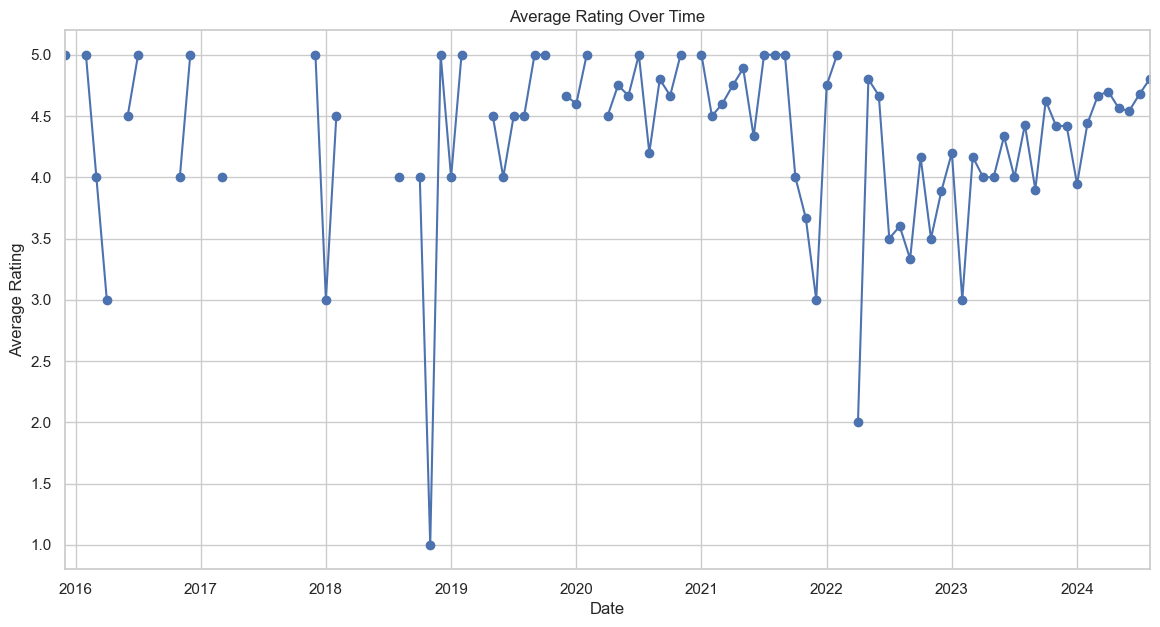

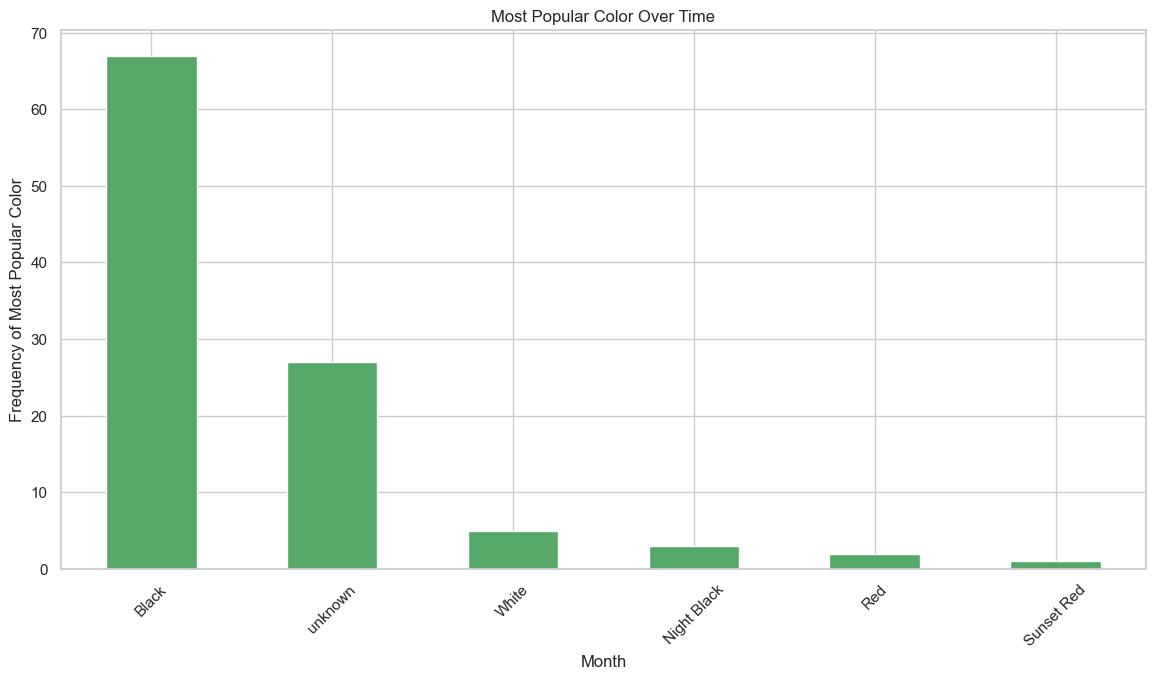

In [181]:
# Check if 'timestamp' is already set as index
if 'timestamp' not in dfclean.columns:
    df_cleaned.reset_index(inplace=True)

# Set the 'timestamp' as the index for easier time series analysis
dfclean.set_index('timestamp', inplace=True)

# Resample data to monthly frequency for trend analysis
ratings_over_time = dfclean['rating'].resample('M').mean()
colors_over_time = dfclean.resample('M')['color'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Plotting the average rating over time
plt.figure(figsize=(14, 7))
ratings_over_time.plot(marker='o', linestyle='-', color='b')
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# Plotting the most popular color over time as a bar plot with months labeled
plt.figure(figsize=(14, 7))
colors_over_time.value_counts().plot(kind='bar', color='g')
plt.title('Most Popular Color Over Time')
plt.xlabel('Month')
plt.ylabel('Frequency of Most Popular Color')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [29]:
pilldf = df_new[df_new['product_name']=='Beats Pill'][['timestamp', 'rating', 'color']]
pilldf['month/year'] = pilldf['timestamp'].dt.to_period('M')
monthly_avg_rating = pilldf.groupby('month/year')['rating'].mean().round(1)

monthly_avg_rating

month/year
2024-06    4.5
2024-07    4.5
2024-08    5.0
Freq: M, Name: rating, dtype: float64

(array([], dtype=int64), [])

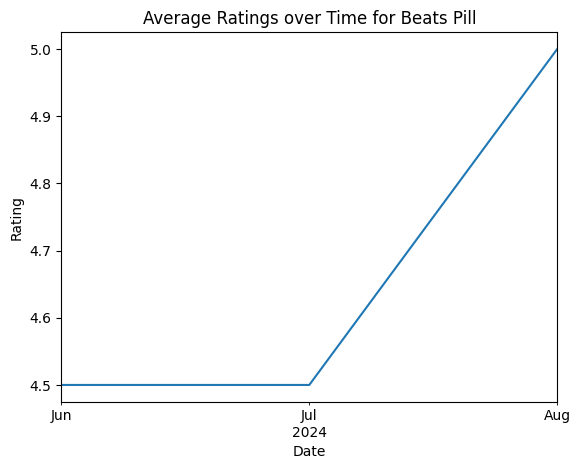

In [30]:
#create plot
monthly_avg_rating.plot(kind='line')
plt.title('Average Ratings over Time for Beats Pill')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.xticks(rotation=45)

**Scatter plots for relationships:**

* Helpful count vs rating
* Color vs rating
* Timestamp vs color
* Rating vs timestamp

### Descriptive Statistics

Descriptive statistics are fundamental for summarizing and describing the main features of a dataset. They provide a snapshot of the data, highlighting key aspects like central tendency, dispersion, and distribution.

In [39]:
# Calculate descriptive statistics

# 1. Measures of Central Tendency:
print("mean =", dfclean['rating'].mean()) # Mean - .mean()
print("median =", dfclean['rating'].median())# Median - .median()
print("mmode =", dfclean['rating'].mode()[0])# Mode - .mode()

# 2. Measures of Data Dispersion
print("variance =", dfclean['rating'].var())# Variance - .var()
print("standard deviation =", dfclean['rating'].std()) # Standard deviation - .std()

# 3. Measures of Data Distribution
print("quantiles =", dfclean['rating'].quantile([0, 0.25, 0.5, 0.75])) # Quantiles - .quantile([0, 0.25, 0.5, 0.75])
# Percentiles

mean = 4.560123329907502
median = 5.0
mmode = 5
variance = 0.8371736473255259
standard deviation = 0.9149719379989344
quantiles = 0.00    1.0
0.25    5.0
0.50    5.0
0.75    5.0
Name: rating, dtype: float64


### Correlation Analysis

Correlation analysis helps in understanding the relationships between variables in your dataset. It allows you to see how variables change in relation to each other. We'll be discussing the following key concepts within correlation analysis:

* Correlation Between Pairs of Data
* Covariance
* Correlation Coefficient
* Visualizing Correlation

1. Correlation Between Pairs of Data

2. Covariance

In [40]:
# Set x and y
x = dfclean['rating']
y = dfclean['product_price']

# Calculate covariance matrix
cov_matrix = np.cov(x, y)
print("Covariance Matrix:\\n", cov_matrix)

# Extract covariance of x and y
cov_xy = cov_matrix[0, 1]
print("Covariance of x and y:", cov_xy)

Covariance Matrix:\n [[ 8.37173647e-01 -9.17506598e-01]
 [-9.17506598e-01  3.62373529e+03]]
Covariance of x and y: -0.9175065978962843


In [41]:
# Calculate covariance using pandas
cov_xy = x.cov(y)
print("Covariance of x and y (pandas):", cov_xy)

Covariance of x and y (pandas): -0.9175065978962843


3. Correlation Coefficient

In [49]:
# Calculate correlation coefficient using scipy
r, p_value = pearsonr(x, y)
print(f"Correlation: {r:.3f}")
print(f"p-value: {p_value:.3f}")

Correlation: -0.017
p-value: 0.604


In [50]:
# Calculate correlation coefficient using pandas
r = x.corr(y)
print(f"Correlation Coefficient (pandas): {r:.3f}")

Correlation Coefficient (pandas): -0.017


4. Visualizing Correlation

Correlation can be visualized using scatter plots and heatmaps.

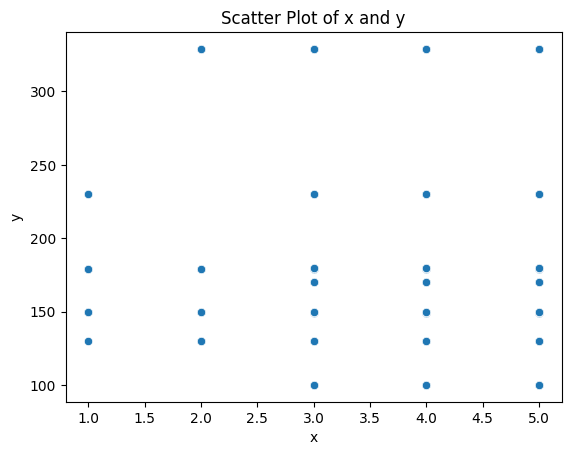

In [51]:
# Scatter plot
sns.scatterplot(x=x, y=y)
plt.title('Scatter Plot of x and y')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

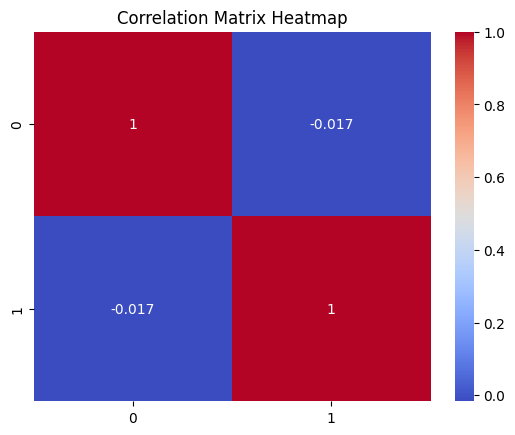

In [52]:
# Heatmap of the correlation matrix
corr_matrix = np.corrcoef(x, y)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Covariance Matrix:\n [[  0.83717365  -2.26618071]
 [ -2.26618071 387.35807544]]
Correlation Matrix:\n [[ 1.        -0.1258434]
 [-0.1258434  1.       ]]


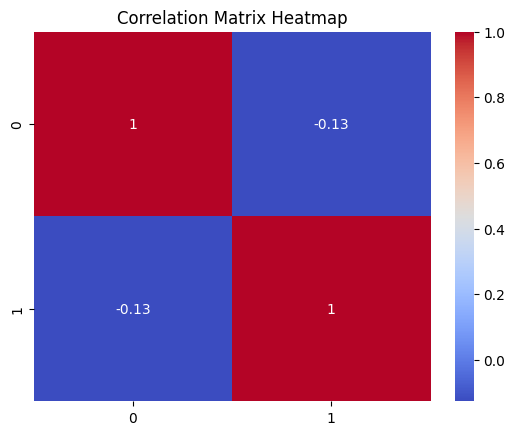

In [53]:
# Set x and y
x = dfclean['rating']
y = dfclean['helpful_count']

# Calculate covariance matrix
cov_matrix = np.cov(x,y)
print("Covariance Matrix:\\n", cov_matrix)

# Calculate correlation matrix
corr_matrix = np.corrcoef(x,y)
print("Correlation Matrix:\\n", corr_matrix)

# Visualize correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
g = sns.FacetGrid(dfclean, col="time", row="smoker")
g.map(sns.scatterplot, "rating", "tip")
plt.show()

## Sentiment Analysis

* Grasp the basics of sentiment analysis and its importance in NLP.
* Use Python libraries like NLTK and TextBlob to analyze sentiments in text data.
* Draw meaningful insights from sentiment analysis to understand consumer preferences and concerns.

In other words, sentiment analysis is a technique used to determine the emotional tone behind a series of words. This helps us understand the attitudes, opinions, and emotions expressed within an online mention or piece of feedback.

Understanding sentiment is crucial for businesses. It helps them gauge public opinion, monitor brand reputation, improve customer service, and even predict market trends.

✍🏽 The output of the sentiment analysis provides a sentiment object with two keys:

* **Polarity Score:** Ranges from -1 (negative) to 1 (positive). A higher positive score indicates a more positive sentiment.
* **Subjectivity Score:** Ranges from 0 (objective) to 1 (subjective). It shows how much of the text is subjective or based on personal opinion.

In [106]:
from textblob import TextBlob

In [107]:
# Select text
print(dfclean['content'][0])
text = dfclean['content'][0]

# Perform sentiment analysis
blob = TextBlob(text)
sentiment = blob.sentiment
print(sentiment)

A few months ago I had an epiphany When I was a kid my father loved to have the best in sound equipment in the house and I would play with graphic equalizers and lay in the floor looking for the best position between the giant speakers to experiment how to better enjoy the music Today I hear music in monophonic audio in an old JBL Charge 3 speaker don t tell my dad he would be ashame of me So I started to get better equipment Now I live in a small apartment with thin walls in a 3rd floor so big amplifiers and so are out of the question but at least I could get better bluetooth speakers so I tried the Marshall Emberton II To say that I impressed with the sound would be an understatement With out of the box settings the sound is more than detailed 80s and 90s music sound outstanding although Peter Cetera s Glory of Love and Toto s Africa vocals sound as I never heard them before they are sharp and strong sometimes detracting just a little from the overall sound keywords here really just 

For this review, the sentiment is more positive and based nearly evenly on personal opinion and objectivity, but slightly moreso on objectivity.

In [2]:
from wordcloud import WordCloud

A few months ago I had an epiphany When I was a kid my father loved to have the best in sound equipment in the house and I would play with graphic equalizers and lay in the floor looking for the best position between the giant speakers to experiment how to better enjoy the music Today I hear music in monophonic audio in an old JBL Charge 3 speaker don t tell my dad he would be ashame of me So I started to get better equipment Now I live in a small apartment with thin walls in a 3rd floor so big amplifiers and so are out of the question but at least I could get better bluetooth speakers so I tried the Marshall Emberton II To say that I impressed with the sound would be an understatement With out of the box settings the sound is more than detailed 80s and 90s music sound outstanding although Peter Cetera s Glory of Love and Toto s Africa vocals sound as I never heard them before they are sharp and strong sometimes detracting just a little from the overall sound keywords here really just 

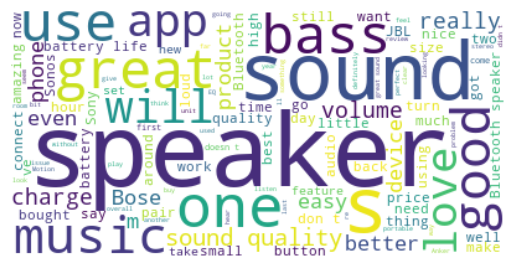

In [59]:
text = ' '.join(dfclean['content'].dropna())
print(text)

# create a world cloud
world_cloud = WordCloud(background_color='white').generate(text)

# visualize world cloud
plt.imshow(world_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusion